In [2]:
import csv
import os
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
BASE_PATH = './tweets/'

In [4]:
def getTop500TwitterUsers():
    users500 = 'top500accounts.txt'
    names = [];
    with open(users500, 'r') as f:
        for line in f.readlines():
            names.append( line[:-1] )
    return names

In [5]:
def getTweetsOfUser( user ):
    global BASE_PATH
    user_file = os.path.join( BASE_PATH, user + '_tweets.csv' )
    try:
        csv_reader = csv.reader( open( user_file, 'r' ) )
        next(csv_reader, None)  # skip the headers
        return( [
            {'text':row[2],
             'retweet_count':int(row[5]),
             'favorite_count':int(row[6]) } for row in csv_reader ] )
    except:
        return []

In [9]:
def getTop500UserTweets():
    allTweets = {}
    top500PlusUsers = getTop500TwitterUsers()
    userNumber = 0;
    for user in top500PlusUsers:
        tweetInfo = getTweetsOfUser( user )
        if len(tweetInfo) == 0:
            continue
        allTweets[user] = tweetInfo;
        userNumber = userNumber + 1;
        if userNumber == 500:
            return allTweets
    return allTweets

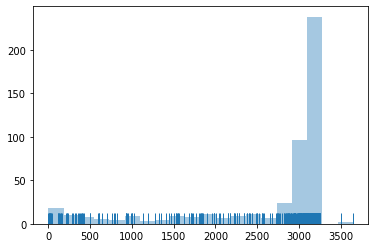

In [10]:
#1. twitter has limit of ~3200 last tweets of any given user - so we expect majority of users having there tweets around that
#2. Also we skip the users with no tweets during preprocessing
allTweets = getTop500UserTweets()
max_tweets_we_have = [ len(allTweets[user]) for user in allTweets.keys() ];
sns.distplot(max_tweets_we_have, bins=20, kde=False, rug=True);

### Let's figure out similarities between tweets of different users - idea is to take last ~3200 tweets ( or less, if total tweets by user ever are less than that ) and use that to figure out similarities between the users in terms of tweets i.e. each user is a data point with features being word vector where each element of vector is representation of proportion of that word in all his/her tweets.

### FIRST, we will take all the tweets of given user that we have. Later we will tweak it and see how it changes relationships!

In [11]:
twitter_users = list( allTweets.keys() )

In [12]:
all_words = {}
for user in twitter_users:
    for tweet in allTweets[user]:
        text = tweet['text']
        for word in text.split(' '):
            try:
                all_words[word] = all_words[word] + 1
            except:
                all_words[word] = 1

In [13]:
total_tweets = sum( [len(allTweets[user]) for user in twitter_users] )
print('Total tweets in our dataset are : %d' % (total_tweets) )
total_words = sum( [ all_words[word] for word in all_words.keys() ] )
print('Total words in our dataset are : %d' % (total_words) )
total_unique_words = len( all_words.keys() )
print('Total unique words in our dataset are : %d' % (total_unique_words))

Total tweets in our dataset are : 1283636
Total words in our dataset are : 9256481
Total unique words in our dataset are : 689926


In [14]:
tweets_corpus = [] #we add it in order of users we have in variable twitter_users
for user in twitter_users:
    all_user_tweets = [ tweet['text'] for tweet in allTweets[user] ]
    tweet_corpus = ' '.join(all_user_tweets)
    tweets_corpus.append( tweet_corpus )

In [15]:
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), norm='l2',
                             smooth_idf=True, sublinear_tf=False, use_idf=True)

In [16]:
X = vectorizer.fit_transform(tweets_corpus)

In [17]:
# similarity matrix - how similar two users are! using fact that angle between them is very small
# note that vector for each user is normalized already, so we don't need to divide by norm of them to get cosine value
similarity = (X * X.T).todense()
# Before we visualize it, let's quickly do some dirty check to find users closer to each other

In [19]:
close_users = []
limit = 0.8
for i in range(similarity.shape[0]):
    for j in range(similarity.shape[1]):
        if i == j:
            continue
        if similarity[i,j] > limit:
            pair = [ twitter_users[i], twitter_users[j] ]
            pair.sort()
            close_users.append('_'.join(pair))
close_users = [ x.split('_') for x in set(close_users) ]
close_users

[['LukeBryanOnline', 'RyanSeacrest'],
 ['felipeneto', 'rafinhabastos'],
 ['TweetRAMALAN', 'kata2bijak'],
 ['VEJA', 'g1'],
 ['CNN', 'cnni'],
 ['LukeBryanOnline', 'katyperry'],
 ['NetflixBrasil', 'whindersson'],
 ['POTUS', 'WhiteHouse'],
 ['RyanSeacrest', 'katyperry']]

#### We see that POTUS and whitehouse are closer in the hyperspace, no surprises there. We see similarities between katyparry and lukeBryan too, again both are american singers, so shouldn't be unexpected. Other is VEJA and g1, both are brazil news channels!

In [23]:
# Time to visualize
tsne = TSNE( n_components=2, verbose=1, perplexity=40, n_iter=10000 )
tsne_results = tsne.fit_transform( similarity )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 483 samples in 0.003s...
[t-SNE] Computed neighbors for 483 samples in 0.224s...
[t-SNE] Computed conditional probabilities for sample 483 / 483
[t-SNE] Mean sigma: 0.424945
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.308792
[t-SNE] KL divergence after 1600 iterations: 0.457174


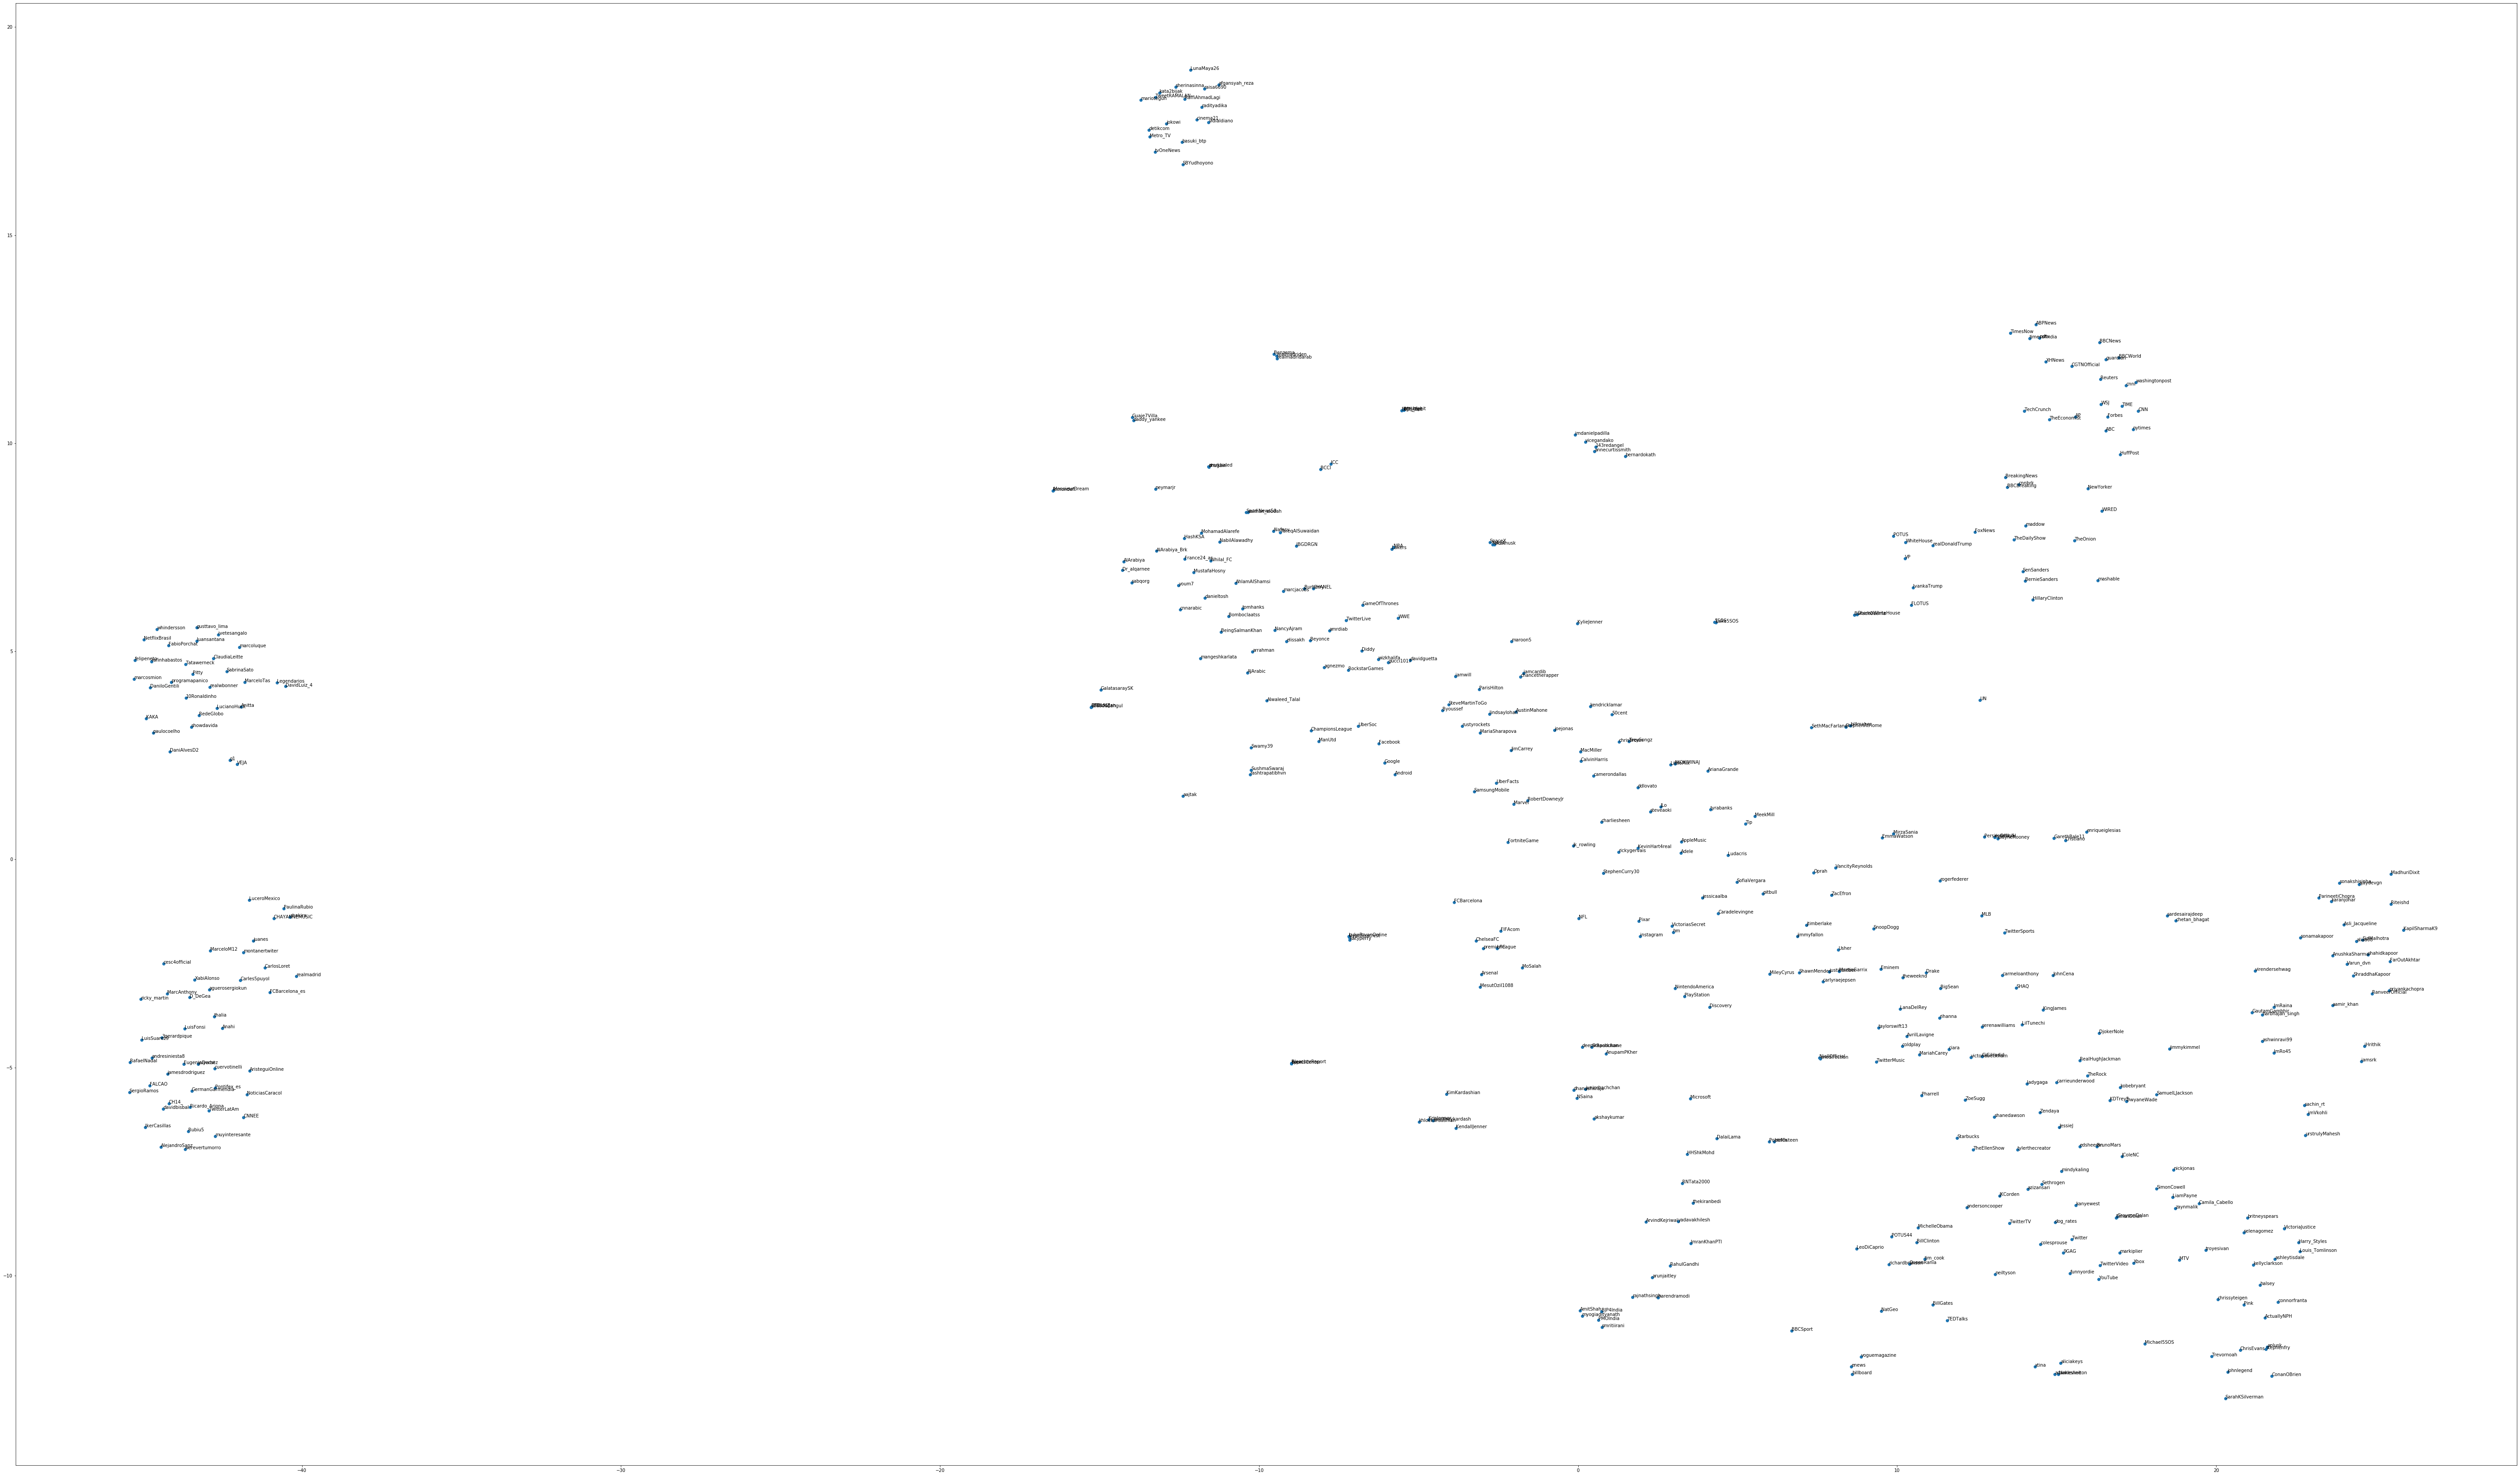

In [24]:
X = tsne_results[:,0]
Y = tsne_results[:,1]
fig,ax = plt.subplots(1,1,figsize=(100,60))
ax.scatter(X,Y)
for i,user in enumerate(twitter_users):
    ax.annotate(user, (X[i],Y[i]))  #this is not very easy to see...

### We see interesting clusters being formed in there!! To better visualize it, let's divide the top 500 users into few categories and then use different colors to plot them to conclude if people within same category come together. I will later also show other observations of what kind of accounts are together

#### Important thing to note, we took all the tweets of given user that we have. This might lead to incorrect similarities between any two users, however FOR NOW we assume that, similar kind of users have similar number of tweets, but we will empirically try to check that in later iterations

In [31]:
import pickle
data = [X,Y,twitter_users]
with open('./twitter_user_tnse_result.pickle', 'wb') as f:
    pickle.dump(data, f)